# Image Classification using CNNs for GTSRB Dataset

The German Traffic Sign Recognition Benchmark (GTSRB) dataset is widely used in computer vision and machine learning. The dataset consists of images of various traffic signs commonly found in Germany, including speed limit signs, yield signs, stop signs, and many others. These images are captured under different lighting conditions, weather conditions, and viewpoints, making it challenging for algorithms to accurately classify and recognize the signs. The classification dataset contains **43 classes of German traffic signs.** The entire dataset (Train and Test) contains over 50,000 images.

Table of Contents

1. [Download and Extract the Dataset](#Download-and-Extract-the-Dataset)
2. [Dataset and Training Configuration](#Dataset-and-Training-Configuration)
3. [Prepare GTSRB Dataset](#prepare-gtsrb-dataset)
4. [Model Definition and Training](#model-definition-and-training)
5. [Plot Results](#plot-results)
6. [Evaluate in the Test Dataset](#evaluate-in-the-test-dataset)


In [1]:
import os
import gc
import torch
import multiprocessing

import numpy as np
import seaborn as sns
import torchvision as tv
import torchmetrics as tm
import matplotlib.pyplot as plt
import torch.nn.functional as F

from tqdm import tqdm

from dataclasses import dataclass

from torchinfo import summary
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import v2
from torchmetrics.classification import (
    MulticlassAccuracy,
    ConfusionMatrix,
    Recall,
    Precision,
)

In [2]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
def get_default_device():
    if torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Download and Extract the Dataset


In [4]:
train_dataset = tv.datasets.GTSRB(root="./data", split="train", download=True)
tests_dataset = tv.datasets.GTSRB(root="./data", split="test", download=True)

## Dataset and Training Configuration


Here we can use the Python dataclasses module to create two classes to configure data and training hyperparameters conveniently


In [ ]:
@dataclass(frozen=True)
class DatasetConfig:
    HEIGHT: int = 64
    WIDTH: int = 64
    CHANNELS: int = 3
    NUM_CLASSES: int = 43


@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE: int = 32
    EPOCHS: int = 30
    LEARNING_RATE: float = 3e-3
    WEIGHT_DECAY: float = 1e-4
    NUM_WORKERS: int = 0
    BREAK_AFTER_IT = None
    ROOT_DIR: str = "./"

The following is the mapping of the class id's to their actual class names


In [6]:
classes = {
    0: "Speed limit (20km/h)",
    1: "Speed limit (30km/h)",
    2: "Speed limit (50km/h)",
    3: "Speed limit (60km/h)",
    4: "Speed limit (70km/h)",
    5: "Speed limit (80km/h)",
    6: "End of speed limit (80km/h)",
    7: "Speed limit (100km/h)",
    8: "Speed limit (120km/h)",
    9: "No passing",
    10: "No passing veh over 3.5 tons",
    11: "Right-of-way at intersection",
    12: "Priority road",
    13: "Yield",
    14: "Stop",
    15: "No vehicles",
    16: "Veh > 3.5 tons prohibited",
    17: "No entry",
    18: "General caution",
    19: "Dangerous curve left",
    20: "Dangerous curve right",
    21: "Double curve",
    22: "Bumpy road",
    23: "Slippery road",
    24: "Road narrows on the right",
    25: "Road work",
    26: "Traffic signals",
    27: "Pedestrians",
    28: "Children crossing",
    29: "Bicycles crossing",
    30: "Beware of ice/snow",
    31: "Wild animals crossing",
    32: "End speed + passing limits",
    33: "Turn right ahead",
    34: "Turn left ahead",
    35: "Ahead only",
    36: "Go straight or right",
    37: "Go straight or left",
    38: "Keep right",
    39: "Keep left",
    40: "Roundabout mandatory",
    41: "End of no passing",
    42: "End no passing veh > 3.5 tons",
}

(np.float64(-0.5), np.float64(36.5), np.float64(33.5), np.float64(-0.5))

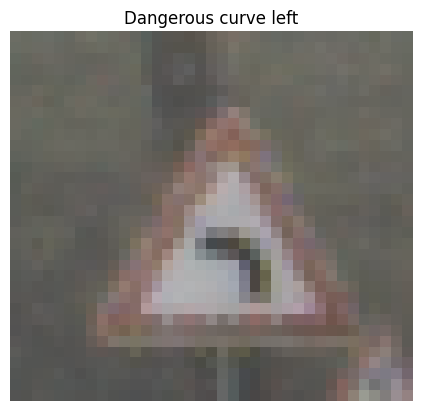

In [7]:
image = train_dataset[np.random.randint(len(train_dataset))]

plt.title(classes[image[1]])
plt.imshow(image[0])
plt.axis("off")

Estimate class weights for unbalanced dataset


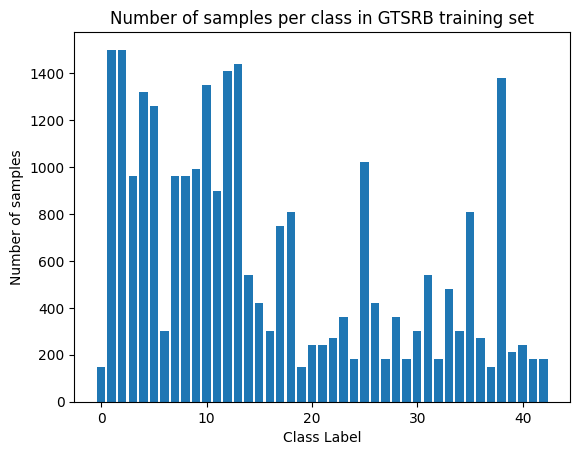

In [8]:
counts = np.bincount([label for _, label in train_dataset])
weights = torch.tensor(np.sum(counts) / (len(classes) * counts), dtype=torch.float32)

plt.bar(np.arange(len(counts)), counts)
plt.xlabel("Class Label")
plt.ylabel("Number of samples")
plt.title("Number of samples per class in GTSRB training set")
plt.show()

## Prepare GTSRB Dataset


In [9]:
def get_preprocess_transforms(resize_to=(32, 32)):
    transforms = v2.Compose(
        [
            v2.Resize(resize_to),
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.PILToTensor(),
        ]
    )
    return transforms

In [10]:
def get_common_transforms(
    resize_to, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
):
    preprocess = get_preprocess_transforms(resize_to=resize_to)

    common_transforms = v2.Compose([preprocess, v2.Normalize(mean, std)])

    return common_transforms

In [11]:
def get_mean_std(dataset, resize_to=(32, 32), batch_size=128, num_workers=4):

    pre_transforms = get_preprocess_transforms(resize_to=resize_to)
    dataset.transform = pre_transforms
    data_loader = DataLoader(
        dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers
    )

    batch_mean = torch.zeros(DatasetConfig.CHANNELS)
    batch_mean_sq = torch.zeros(DatasetConfig.CHANNELS)

    for batch_data, _ in tqdm(
        iterable=data_loader,
        ascii=True,
        total=len(data_loader),
        desc="Computing MEAN & STD",
    ):
        batch_mean += torch.mean(batch_data, dim=(0, 2, 3))
        batch_mean_sq += torch.mean(batch_data**2, dim=(0, 2, 3))

    mean = batch_mean / len(data_loader)
    # var[X] = E[X**2] - E[X]**2
    var = (batch_mean_sq / len(data_loader)) - (mean**2)
    std = var**0.5

    print("Mean: {}, Std: {}".format(mean, std))

    return mean, std

In [12]:
def get_data(
    dataset,
    tests_dataset,
    resize_to=(32, 32),
    batch_size=32,
    data_augmentation=False,
    num_workers=0,
):

    MEAN = 0
    STD = 1

    MEAN, STD = get_mean_std(dataset, resize_to=resize_to, num_workers=2)

    common_transforms = get_common_transforms(resize_to=resize_to, mean=MEAN, std=STD)

    if data_augmentation:

        transforms = v2.Compose(
            [
                common_transforms,
                v2.RandomAffine(
                    degrees=(-0.2, 0.2), translate=(0.2, 0.2), scale=(0.90, 1.1)
                ),
            ]
        )
    else:
        transforms = common_transforms

    train_dataset, valid_dataset = torch.utils.data.random_split(
        dataset, lengths=(0.8, 0.2)
    )

    train_dataset.transform = transforms  # type: ignore
    train_dataloader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers
    )

    valid_dataset.transform = transforms  # type: ignore
    valid_dataloader = DataLoader(
        valid_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers
    )

    tests_dataset.transform = transforms  # type: ignore
    tests_dataloader = DataLoader(
        tests_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers
    )

    return train_dataloader, valid_dataloader, tests_dataloader

In [13]:
train_dataloader, valid_dataloader, test_dataloader = get_data(
    train_dataset,
    tests_dataset,
    resize_to=(DatasetConfig.HEIGHT, DatasetConfig.WIDTH),
    batch_size=TrainingConfig.BATCH_SIZE,
    num_workers=TrainingConfig.NUM_WORKERS,
    data_augmentation=False,
)

Computing MEAN & STD: 100%|##########| 209/209 [00:13<00:00, 16.06it/s] 

Mean: tensor([0.3410, 0.3119, 0.3209]), Std: tensor([0.2761, 0.2638, 0.2697])


## Model Definition and Training


In [14]:
class CBRBlock(torch.nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size) -> None:
        super().__init__()
        self.model_ = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                padding="same",
            ),
            torch.nn.BatchNorm2d(num_features=out_channels),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
        )

    def forward(self, X):
        return self.model_(X)

In [15]:
class SignNet(torch.nn.Module):

    def __init__(self, in_channels, num_classes, dropout_rate=0.5) -> None:
        super().__init__()

        self.model_ = torch.nn.Sequential(
            CBRBlock(in_channels, 32, 3),
            CBRBlock(32, 64, 3),
            CBRBlock(64, 128, 3),
            CBRBlock(128, 256, 3),
            CBRBlock(256, 512, 3),
            torch.nn.AdaptiveMaxPool2d(output_size=(1, 1)),
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=512, out_features=256),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout_rate),
            torch.nn.Linear(in_features=256, out_features=128),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout_rate),
            torch.nn.Linear(in_features=128, out_features=num_classes),
        )

    def forward(self, input):
        x = self.model_(input)
        return x

In [16]:
def initialize_weights(m):
    if isinstance(m, torch.nn.Linear):
        # Xavier uniform initialization for linear layers
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)
    elif isinstance(m, torch.nn.Conv2d):
        # Kaiming uniform initialization (He initialization) for Conv2d layers
        torch.nn.init.kaiming_uniform_(m.weight, nonlinearity="relu")
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)
    elif isinstance(m, torch.nn.BatchNorm2d):
        # BatchNorm layers are often initialized differently
        torch.nn.init.normal_(m.weight, mean=1.0, std=0.02)
        torch.nn.init.zeros_(m.bias)

In [17]:
model = SignNet(
    in_channels=DatasetConfig.CHANNELS, num_classes=DatasetConfig.NUM_CLASSES
)

model.apply(initialize_weights)

summary(
    model,
    depth=2,
    col_names=["input_size", "output_size", "num_params"],
    input_data=torch.ones(
        TrainingConfig.BATCH_SIZE,
        DatasetConfig.CHANNELS,
        DatasetConfig.HEIGHT,
        DatasetConfig.WIDTH,
    ),
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
SignNet                                  [32, 3, 64, 64]           [32, 43]                  --
├─Sequential: 1-1                        [32, 3, 64, 64]           [32, 43]                  --
│    └─CBRBlock: 2-1                     [32, 3, 64, 64]           [32, 32, 32, 32]          960
│    └─CBRBlock: 2-2                     [32, 32, 32, 32]          [32, 64, 16, 16]          18,624
│    └─CBRBlock: 2-3                     [32, 64, 16, 16]          [32, 128, 8, 8]           74,112
│    └─CBRBlock: 2-4                     [32, 128, 8, 8]           [32, 256, 4, 4]           295,680
│    └─CBRBlock: 2-5                     [32, 256, 4, 4]           [32, 512, 2, 2]           1,181,184
│    └─AdaptiveMaxPool2d: 2-6            [32, 512, 2, 2]           [32, 512, 1, 1]           --
│    └─Flatten: 2-7                      [32, 512, 1, 1]           [32, 512]                 --
│    └─Linear:

In [18]:
def train_model(
    model,
    config,
    optimizer: torch.optim.Optimizer,
    criterion,
    scheduler,
    train_dataloader: torch.utils.data.DataLoader,
    valid_dataloader: torch.utils.data.DataLoader,
    device,
    early_stopping=None,
    model_name=None,
    checkpoint_path=None,
    break_after_it=None,
):
    train_results = []
    valid_results = []

    N = config.EPOCHS * len(train_dataloader) + config.EPOCHS * len(valid_dataloader)
    progress = tqdm(total=N, desc="Training Progress", leave=True)

    scaler = torch.amp.GradScaler(device)  # type: ignore

    model = model.to(device)
    train_loss = float("inf")
    val_loss = float("inf")

    acc = float("inf")
    val_acc = float("inf")

    acc_record = MulticlassAccuracy(num_classes=len(classes), average="micro")
    acc_valid = MulticlassAccuracy(num_classes=len(classes), average="micro")

    for epoch in range(config.EPOCHS):
        model.train()
        for i, batch in enumerate(train_dataloader):
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            if device == "cuda":
                with torch.autocast(device_type=device, dtype=torch.bfloat16):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()

            train_loss = loss.item()

            pred = torch.argmax(outputs, dim=1)
            acc_record.update(pred.cpu(), labels.cpu())

            acc = acc_record.compute()

            progress.set_postfix(
                {
                    "epoch": f"{epoch + 1}",
                    "loss": f"{train_loss:.4f}",
                    "val_loss": f"{val_loss:.4f}",
                    "acc": f"{acc:.4f}",
                    "val_acc": f"{val_acc:.4f}",
                    "lr": f"{scheduler.get_last_lr()[0]:.6f}",
                }
            )

            train_results.append(
                [epoch + ((i + 1) / len(train_dataloader)), train_loss, acc]
            )
            progress.update(1)

            if break_after_it is not None and i > break_after_it:
                break

        model.eval()
        for i, batch in enumerate(valid_dataloader):
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss = loss.item()

            pred = torch.argmax(outputs, dim=1)
            acc_valid.update(pred.cpu(), labels.cpu())

            val_acc = acc_valid.compute()

            progress.set_postfix(
                {
                    "epoch": f"{epoch + 1}",
                    "loss": f"{train_loss:.4f}",
                    "val_loss": f"{val_loss:.4f}",
                    "acc": f"{acc:.4f}",
                    "val_acc": f"{val_acc:.4f}",
                    "lr": f"{scheduler.get_last_lr()[0]:.6f}",
                }
            )

            valid_results.append(
                [epoch + ((i + 1) / len(valid_dataloader)), val_loss, val_acc]
            )

            progress.update(1)

            if break_after_it is not None and i > break_after_it:
                break

        if (
            break_after_it is None
            and model_name is not None
            and checkpoint_path is not None
        ):
            checkpoint = {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": model.state_dict(),
                "loss": train_loss,
            }

            torch.save(checkpoint, os.path.join(checkpoint_path, model_name))

        if early_stopping is not None:
            early_stopping.check_early_stop(val_loss)

            if early_stopping.stop_training:
                print(f"Early stopping in epoch: {epoch}")
                break

        if break_after_it is not None:
            break

    # Cleanup
    del model
    del optimizer
    del train_dataloader
    del valid_dataloader

    gc.collect()
    torch.cuda.empty_cache()

    return train_results, valid_results

In [19]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.no_improvement_count = 0
        self.stop_training = False

    def check_early_stop(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.no_improvement_count = 0
        else:
            self.no_improvement_count += 1
            if self.no_improvement_count >= self.patience:
                self.stop_training = True

In [20]:
device = get_default_device()

model = SignNet(in_channels=3, num_classes=len(classes))
optim = torch.optim.Adam(
    model.parameters(),
    lr=TrainingConfig.LEARNING_RATE,
)
criterion = torch.nn.CrossEntropyLoss(weight=weights.to(device), label_smoothing=0.2)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optim,
    max_lr=TrainingConfig.LEARNING_RATE,
    steps_per_epoch=len(train_dataloader),
    epochs=TrainingConfig.EPOCHS,
)
early_stopping = None

train_results, valid_results = train_model(
    model,
    TrainingConfig(),
    optim,
    criterion,
    scheduler,
    train_dataloader,
    test_dataloader,
    device.type,
    early_stopping=early_stopping,
    break_after_it=TrainingConfig.BREAK_AFTER_IT,
    checkpoint_path=os.path.join(TrainingConfig.ROOT_DIR, "models"),
    model_name=SignNet.__name__ + ".checkpoint",
)

torch.save(
    model, os.path.join(TrainingConfig.ROOT_DIR, "models", SignNet.__name__ + ".pt")
)

Training Progress: 100%|██████████| 31830/31830 [08:24<00:00, 63.12it/s, epoch=30, loss=2.3535, val_loss=2.4069, acc=0.9260, val_acc=0.7635, lr=0.000000] 


## Plot Results


Text(0.5, 1.0, 'Training and Validation Loss')

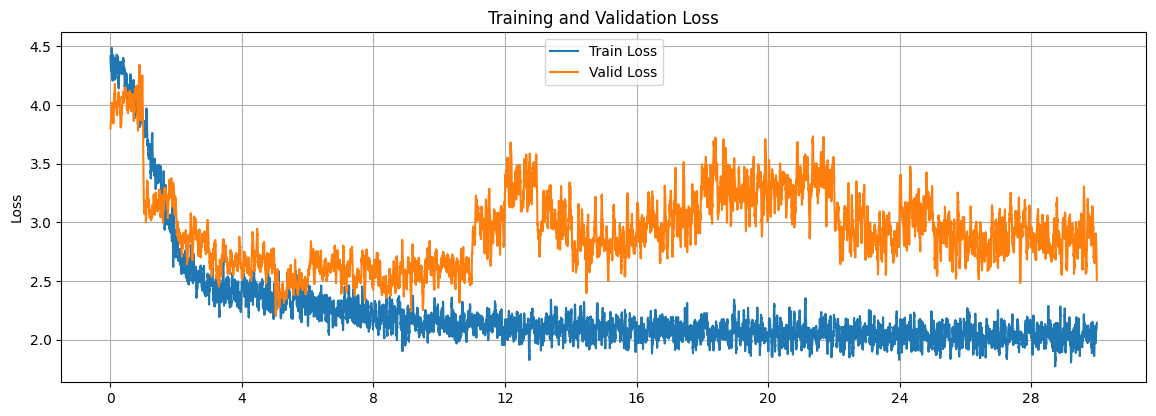

In [21]:
from matplotlib.ticker import MaxNLocator
from scipy.signal import savgol_filter


train_results_np = np.array(train_results)
valid_results_np = np.array(valid_results)
window = 30
polyorder = 2


plt.rcParams["figure.figsize"] = (14, 10)
fig = plt.figure()
fig.set_facecolor("white")


# plot loss
plt.subplot(2, 1, 1)

plt.plot(
    train_results_np[:, 0],
    savgol_filter(train_results_np[:, 1], window_length=window, polyorder=polyorder),
    color="tab:blue",
    label="Train Loss",
)

plt.plot(
    valid_results_np[:, 0],
    savgol_filter(valid_results_np[:, 1], window_length=window, polyorder=polyorder),
    color="tab:orange",
    label="Valid Loss",
)

plt.ylabel("Loss")
plt.legend(loc="upper center")
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid(True)
plt.title("Training and Validation Loss")

Text(0.5, 1.0, 'Training and Validation Acc')

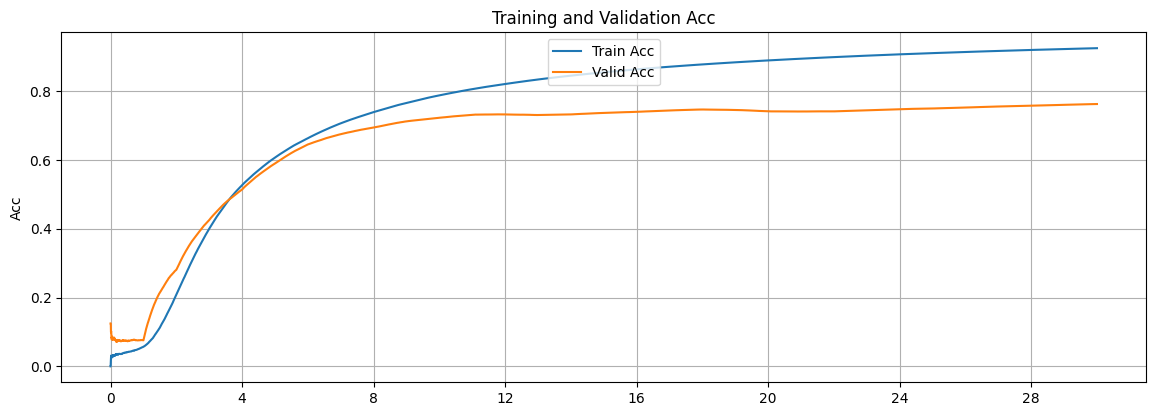

In [22]:
from matplotlib.ticker import MaxNLocator


train_results_np = np.array(train_results)
valid_results_np = np.array(valid_results)


plt.rcParams["figure.figsize"] = (14, 10)
fig = plt.figure()
fig.set_facecolor("white")


# plot loss
plt.subplot(2, 1, 1)

plt.plot(
    train_results_np[:, 0],
    train_results_np[:, 2],
    color="tab:blue",
    label="Train Acc",
)

plt.plot(
    valid_results_np[:, 0],
    valid_results_np[:, 2],
    color="tab:orange",
    label="Valid Acc",
)

plt.ylabel("Acc")
plt.legend(loc="upper center")
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid(True)
plt.title("Training and Validation Acc")

## Evaluate in the Test Dataset


In [23]:
acc = MulticlassAccuracy(num_classes=len(classes), average="micro")
recall = Recall(task="multiclass", num_classes=len(classes), average="micro")
precision = Precision(task="multiclass", num_classes=len(classes), average="micro")
confmat = ConfusionMatrix(task="multiclass", num_classes=len(classes))

Accuracy 0.8308788537979126
Recall 0.8308788537979126
Precision 0.8308788537979126


<Axes: >

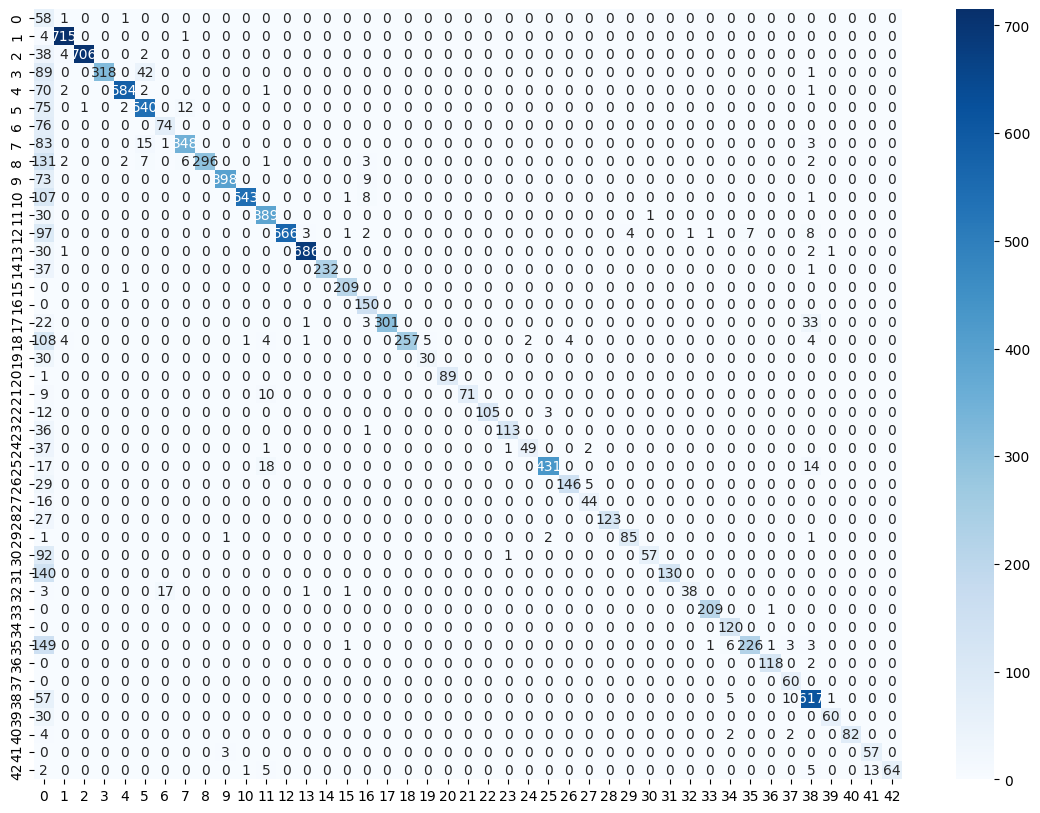

In [24]:
for batch in test_dataloader:
    inputs, labels = batch
    inputs, labels = inputs.to(device), labels.to(device)

    outputs = model(inputs)

    pred = torch.argmax(outputs, dim=1)

    acc.update(pred.cpu(), labels.cpu())
    recall.update(pred.cpu(), labels.cpu())
    precision.update(pred.cpu(), labels.cpu())
    confmat.update(pred.cpu(), labels.cpu())

print("Accuracy {}".format(acc.compute().item()))
print("Recall {}".format(recall.compute().item()))
print("Precision {}".format(precision.compute().item()))

matrix = confmat.compute().numpy()

sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues")